# 2. Feature Extraction
In this notebook, we will extract features from article titles/abstracts for the purpose of clustering the articles, and predicting how many citations they received. Specifically, we will make use of a dataset of 1,124 articles obtained using the following query on Scopus: `"science of science" OR "metascience" OR "meta science"`.

## Environment Setup

In [1]:
import sys
if 'google.colab' in sys.modules:  # If in Google Colab environment
    # Mount google drive to enable access to data files
    from google.colab import drive
    drive.mount('/content/drive')
    
    # Install requisite packages
    !pip install sentence_transformers &> /dev/null

    # Change working directory
    %cd /content/drive/MyDrive/LLM4SciSci

In [2]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.manifold import TSNE
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

## Feature Extraction
The code begins by loading the data as `pandas.DataFrame` objects and concatenating the titles and abstracts into a single column (`'text'`).

In [3]:
# Load the data with only the desired columns
data = pd.read_csv('science_of_science.csv', usecols=['title', 'abstract', 'keywords', 'year', 'citations'])

# Concatenate titles and abstracts
data['text'] = data['title'] + './n/n' + data['abstract']
data

,title,abstract,keywords,year,citations,text
0,Machine learning misclassification networks re...,Given a large enough volume of data and precis...,Interdisciplinary research; Machine learning; ...,2024,3,Machine learning misclassification networks re...
1,Dynamic patterns of the disruptive and consoli...,Scientific breakthroughs possess the transform...,citation network; disruption; Nobel Prize; sci...,2024,2,Dynamic patterns of the disruptive and consoli...
2,Automating the practice of science: Opportunit...,Automation transformed various aspects of our ...,AI for science; automation ; computational sci...,2025,1,Automating the practice of science: Opportunit...
3,Asian American Representation Within Psycholog...,"As a racial group, Asians are incredibly diver...",Asian/Asian American; diversity; intersectiona...,2024,1,Asian American Representation Within Psycholog...
4,Bibliometric analysis of publications on trabe...,"Purpose: Trabecular bone score (TBS), as a tex...",Bone mineral density; Fracture risk; Knowledge...,2024,0,Bibliometric analysis of publications on trabe...
...,...,...,...,...,...,...
1119,The science of science foundation,[No abstract available],NaN,1965,1,The science of science foundation./n/n[No abst...
1120,Bibliographic coupling: A review,The theory and practical applications of bibli...,NaN,1974,224,Bibliographic coupling: A review./n/nThe theor...
1121,Behavioristisk kritik av psykoanalysen,"As fas as metascience is concerned, Schioldbor...",NaN,1971,3,Behavioristisk kritik av psykoanalysen./n/nAs ...
1122,The R & D information gap or the social scienc...,[No abstract available],NaN,1967,0,The R & D information gap or the social scienc...


The code then next initializes the `SentenceTransformer` model `'all-MiniLM-L6-v2'` and extracts features from the training data using the `encode` method.

In [4]:
# Initialize feature extraction pipeline
model = SentenceTransformer('all-MiniLM-L6-v2')

# Extract features
features = model.encode(data['text'], show_progress_bar=True)
features

Batches:   0%|          | 0/36 [00:00<?, ?it/s]

array([[-0.00473206, -0.04576412,  0.01965012, ..., -0.03477446,
         0.02810462,  0.01813718],
       [-0.05819887, -0.06011161,  0.02259039, ..., -0.06635984,
         0.05790947,  0.03990703],
       [-0.06759556,  0.02921594, -0.0322248 , ...,  0.00199628,
         0.01664495, -0.01207595],
       ...,
       [ 0.02056852,  0.00477816, -0.08616947, ...,  0.10622985,
         0.02579156, -0.02725776],
       [ 0.00344623,  0.02273844, -0.06633328, ...,  0.01183059,
        -0.0287214 ,  0.07119869],
       [-0.05497676,  0.01687015, -0.01583676, ..., -0.051455  ,
         0.03415811, -0.0143118 ]], dtype=float32)

To visualize the article features (and reduce there dimensionality for clustering downstream), the code initializes `sklearn`'s [`TSNE`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) uses it to project the features into 3 components.

In [5]:
tsne_3d = TSNE(n_components=3, random_state=42)
features_3d = tsne_3d.fit_transform(features)
features_3d

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


array([[-39.34816  ,   6.117009 , -10.931155 ],
       [-25.803839 ,   1.3947022, -16.234304 ],
       [ -2.207882 ,  11.289228 , -22.565681 ],
       ...,
       [ 33.166267 , -13.272928 ,   7.1375747],
       [  1.8071437,   3.9425175, -10.591645 ],
       [ 34.78501  ,  -0.4610935, -14.247688 ]], dtype=float32)

These components can then be visualized using `matplotlib`'s 3-d plotting functionality:

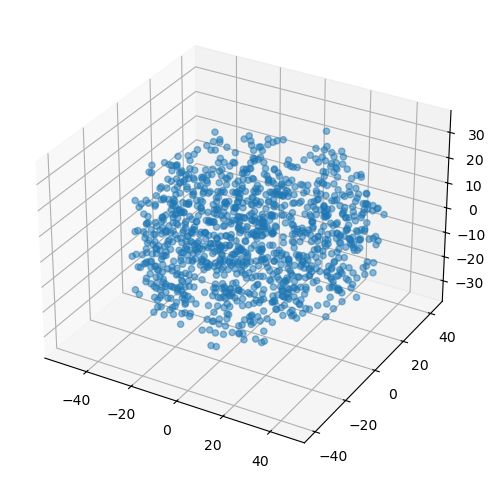

In [23]:
# Plot features using scatterplot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_3d[:, 0], features_3d[:, 1], features_3d[:, 2], alpha=.5)

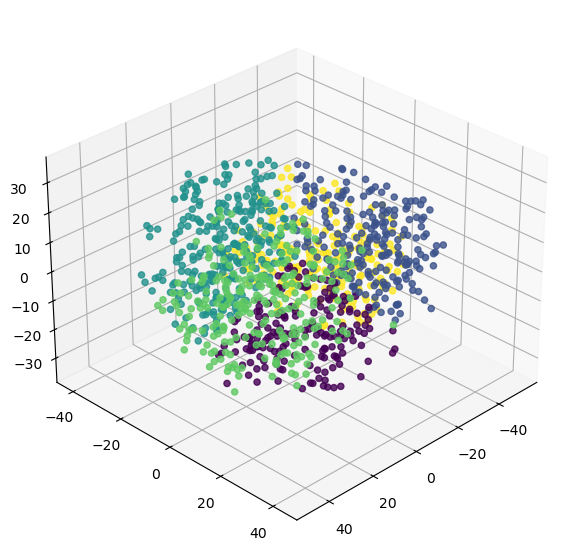

In [27]:
# Cluster using KMeans
kmeans = KMeans(n_clusters=5, random_state=42).fit(features_3d)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    features_3d[:, 0], features_3d[:, 1], features_3d[:, 2],
    c=kmeans.labels_, cmap="viridis", alpha=.8
)
# Rotate the plot
ax.view_init(elev=30, azim=45)  # Adjust angles as needed

**Task 1**: Try adjusting the `elev` and `azim` parameters in the previous line to get a better intuition for the clusters' 3-dimensional structure.

The code next save the cluster labels as a new column (`'cluster'`) in `data` and saves the results to a new csv file in your Google Drive for reuse in the next exercise.

In [ ]:
# Saving the clusters for 3_text_generation
data['cluster'] = pd.Series(kmeans.labels_, dtype=str)
data.to_csv('science_of_science_clusters.csv', index=False)

In order to give the clusters meaningful labels, we can make use of the `'keywords'` column. Specifically, the code counts the number of times each key word occurs in each cluster, and saves the results to `cluster_keyword_counts`.

In [34]:
cluster_keyword_counts = {} # Dictionary for storing keyword counts in each cluster
unique_keywords = set() # Set for storing all unique keywords

# Iterate through each cluster, count the frequency of each keyword
for cluster in data['cluster'].unique():
    # Select rows for the given cluster
    cluster_data = data.query('cluster == @cluster')

    # Concatenate all keywords into a single string, remove surrounding whitespace, and lowercase
    keywords = cluster_data['keywords'].str.cat(sep='').split(';')
    keywords = [keyword.strip().lower() for keyword in keywords]

    # Save
    unique_keywords = unique_keywords.union(set(keywords))

    keyword_counts = Counter(keywords)
    cluster_keyword_counts[cluster] = {keyword.strip().lower(): count for keyword, count in keyword_counts.items()}

# Printing the number of keywords for each cluster after
{cluster: len(keywords) for cluster, keywords in cluster_keyword_counts.items()}

{'4': 571, '0': 432, '2': 652, '1': 641, '3': 665}

The code next reshapes the data in `cluster_keyword_counts` into a `pd.DataFrame` where each row represents a cluster, each column a keyword, and each the number of times that keyword occurs in that cluster.

In [35]:
# Building cluster-keyword count matrix
count_matrix = pd.DataFrame(
    index=cluster_keyword_counts.keys(), columns=list(unique_keywords)
)
for cluster in count_matrix.index:
    for keyword in count_matrix.columns:
        count_matrix.loc[cluster, keyword] = cluster_keyword_counts[cluster].get(keyword, 0)

count_matrix = count_matrix.astype(int) # Convert to int format
count_matrix = count_matrix.loc[:, count_matrix.sum() > 3] # Drop keywords occurring <=3 times
count_matrix

,diagnostic testing,mechanical ventilation,meta-analysis,questionable research practices,generalizability,scholarly data,interdisciplinary,methodology,science policy,covid-19,...,innovation,natural language processing,impact factor,research assessment,network analysis,science communication,replication crisis,science of science policy,history of science,informetrics
4,0,0,0,0,0,1,3,0,3,2,...,7,3,3,0,5,0,1,2,1,2
0,0,0,0,0,3,0,0,4,2,1,...,2,0,0,1,0,5,2,2,0,0
2,4,4,9,8,3,0,0,8,0,1,...,0,2,0,0,0,5,6,0,0,0
1,0,0,1,0,0,14,1,1,1,1,...,8,2,1,5,3,0,1,2,1,7
3,0,0,0,2,1,0,1,1,0,1,...,0,1,0,0,0,1,0,0,5,0


In [36]:
def compute_pmi(df):
    mat = df.to_numpy(dtype=np.float64)  # Convert DataFrame to NumPy array
    p = mat / np.sum(mat)  # Compute probability matrix

    row_sums = np.sum(p, axis=1, keepdims=True)
    col_sums = np.sum(p, axis=0, keepdims=True) ** 0.7

    expected = row_sums @ col_sums  # Outer product of row and column sums
    pmi = p / expected  # Compute PMI matrix

    return pd.DataFrame(pmi, index=df.index, columns=df.columns)


# Compute pmi
pmi_matrix = compute_pmi(count_matrix)
pmi_matrix

,diagnostic testing,mechanical ventilation,meta-analysis,questionable research practices,generalizability,scholarly data,interdisciplinary,methodology,science policy,covid-19,...,innovation,natural language processing,impact factor,research assessment,network analysis,science communication,replication crisis,science of science policy,history of science,informetrics
4,0.00000,0.00000,0.000000,0.000000,0.000000,0.075614,0.489450,0.000000,0.430806,0.287204,...,0.484898,0.352229,0.572197,0.000000,0.587048,0.000000,0.100431,0.287204,0.128913,0.216235
0,0.00000,0.00000,0.000000,0.000000,0.820005,0.000000,0.000000,0.673030,0.608959,0.304479,...,0.293751,0.000000,0.000000,0.304479,0.000000,0.995999,0.425886,0.608959,0.000000,0.000000
2,0.50862,0.50862,0.602584,0.535630,0.257827,0.000000,0.000000,0.423229,0.000000,0.095735,...,0.000000,0.156546,0.000000,0.000000,0.000000,0.313163,0.401723,0.000000,0.000000,0.000000
1,0.00000,0.00000,0.124764,0.000000,0.000000,1.315085,0.202680,0.098583,0.178395,0.178395,...,0.688439,0.291714,0.236945,0.891977,0.437570,0.000000,0.124764,0.356791,0.160148,0.940195
3,0.00000,0.00000,0.000000,0.464286,0.297980,0.000000,0.377117,0.183428,0.000000,0.331933,...,0.000000,0.271389,0.000000,0.000000,0.000000,0.217160,0.000000,0.000000,1.489900,0.000000


In [37]:
# Get top 5 highest-PMI keywords
top_keywords = pmi_matrix.apply(lambda row: row.nlargest(5).index.tolist(), axis=1)
top_keywords

4    [science of science, computational social science, nobel prize, disruption, high-skilled migration]
0                        [data analytics, diversity, collaboration, science communication, meta science]
2                               [replication, metascience, replicability, reproducibility, meta-science]
1                         [scholarly data, knowledge graphs, topic detection, text mining, informetrics]
3                          [knowledge, philosophy of science, history of science, epistemology, science]
dtype: object

The features are then standardised before being fed into `RidgeClassifierCV`. This is crucial, since `RidgeClassifierCV` uses l2 (ridge) regularisation to prevent over-fitting, which assumes that the features have the same scaling. The classifier is then trained on the training data using the `fit` method. Note that `RidgeClassifierCV` will automatically perform cross-validation on the training data to find the best alpha value from the list of `alphas` provided. Performance on the training data is then evaluated using the `score` method.

In [11]:
features = pd.DataFrame(features)
features['age'] = data['year'].max() - data['year']
features.columns = [str(name) for name in features.columns]

X_train, X_test, y_train, y_test = train_test_split(
    features, np.log1p(data['citations']), test_size=0.2, random_state=42
)

# Standardize features
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

# Initialize classifier
ridge = RidgeCV(alphas=np.logspace(-10, 10, 100))

# Train classifier
ridge.fit(X_train, y_train)
f"Train accuracy: {ridge.score(X_train, y_train):.2f}"

'Train accuracy: 0.29'

Features are next extracted for the test set and standardised using the same `StandardScaler` object that was fitted on the training data to prevent data leakage. The classifier is then evaluated on the test data using the `score` method.

In [12]:
# Standardising features
X_test = scaler.transform(X_test)

# Test classifier
f"Test accuracy: {ridge.score(X_test, y_test):.2f}"

'Test accuracy: 0.06'


**TASK 1:** Go to the `SentenceTransformers` [model page](https://sbert.net/docs/sentence_transformer/pretrained_models.html) and find a well-performing model of a slightly larger size than  `'all-MiniLM-L6-v2'` (e.g. `all-mpnet-base-v2'`). Open the Hugging Face model card by clicking on the model name and then the link next to 'Model Card'. Replace the `'all-MiniLM-L6-v2` in the code above with the models name (make sure to copy the full name by clicking on the copy-icon to the right of the name at the top of the page). Re-run the analysis. Does the performance improve?

**TASK 2 (BONUS):** Consider how you might apply the above methods in your own research. If you have dataset in mind, try uploading it to the repository in your Google Drive and loading it into this notebook to run the analysis with your own data (**Caution**: make sure you don't delete the original `science_of_science.csv` dataset, as we will need it for the next exercise).

